In [1]:
from tqdm import tqdm
import os
import time
from random import randint
 
import gc 
import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib
import pydicom as pdm
import nilearn as nl
import nilearn.plotting as nlplt
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output
from IPython.display import YouTubeVideo


# !pip install albumentations==0.4.6
import albumentations as A
# from albumentations.pytorch import ToTensor, ToTensorV2


from albumentations import Compose, HorizontalFlip
# from albumentations.pytorch import ToTensor, ToTensorV2 

import warnings
warnings.simplefilter("ignore")

In [2]:
sample_filename = '/home/rage/Desktop/MiniProject/brats/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii'
sample_filename_mask = '/home/rage/Desktop/MiniProject/brats/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii'
sample_img = nib.load(sample_filename)
sample_img = np.asanyarray(sample_img.dataobj)
sample_img = np.rot90(sample_img)
sample_mask = nib.load(sample_filename_mask)
sample_mask = np.asanyarray(sample_mask.dataobj)
sample_mask = np.rot90(sample_mask)
print("img shape ->", sample_img.shape)
print("mask shape ->", sample_mask.shape)


img shape -> (240, 240, 155)
mask shape -> (240, 240, 155)


In [3]:
sample_filename2 = './brats/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii'
sample_img2 = nib.load(sample_filename2)
sample_img2 = np.asanyarray(sample_img2.dataobj)
sample_img2  = np.rot90(sample_img2)

sample_filename3 = './brats/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii'
sample_img3 = nib.load(sample_filename3)
sample_img3 = np.asanyarray(sample_img3.dataobj)
sample_img3  = np.rot90(sample_img3)

sample_filename4 = './brats/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii'
sample_img4 = nib.load(sample_filename4)
sample_img4 = np.asanyarray(sample_img4.dataobj)
sample_img4  = np.rot90(sample_img4)

# WHOLE TUOMUR / ED - LABEL 2 
mask_WT = sample_mask.copy()
mask_WT[mask_WT == 1] = 1
mask_WT[mask_WT == 2] = 1
mask_WT[mask_WT == 4] = 1

# NCR OR NET - LABEL 1 
mask_TC = sample_mask.copy()
mask_TC[mask_TC == 1] = 1
mask_TC[mask_TC == 2] = 0
mask_TC[mask_TC == 4] = 1

# ET - LABEL 4 
mask_ET = sample_mask.copy()
mask_ET[mask_ET == 1] = 0
mask_ET[mask_ET == 2] = 0
mask_ET[mask_ET == 4] = 1



In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

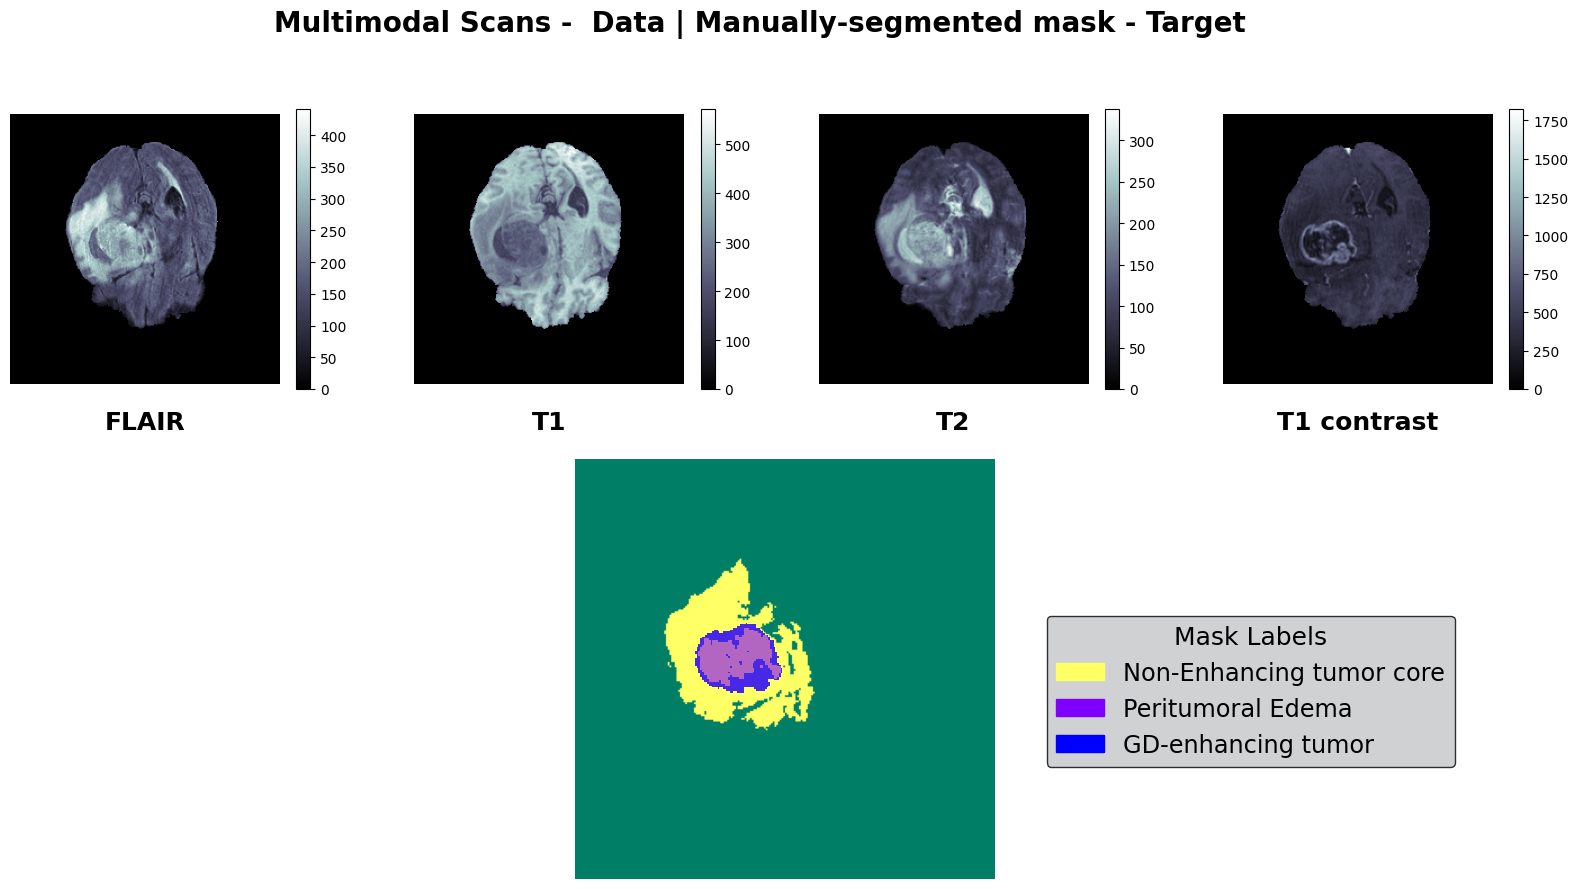

In [5]:
fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 1.5])

#  Varying density along a streamline
ax0 = fig.add_subplot(gs[0, 0])
flair = ax0.imshow(sample_img[:,:,65], cmap='bone')
ax0.set_title("FLAIR", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(flair)

#  Varying density along a streamline
ax1 = fig.add_subplot(gs[0, 1])
t1 = ax1.imshow(sample_img2[:,:,65], cmap='bone')
ax1.set_title("T1", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1)

#  Varying density along a streamline
ax2 = fig.add_subplot(gs[0, 2])
t2 = ax2.imshow(sample_img3[:,:,65], cmap='bone')
ax2.set_title("T2", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t2)

#  Varying density along a streamline
ax3 = fig.add_subplot(gs[0, 3])
t1ce = ax3.imshow(sample_img4[:,:,65], cmap='bone')
ax3.set_title("T1 contrast", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1ce)

#  Varying density along a streamline
ax4 = fig.add_subplot(gs[1, 1:3])

#ax4.imshow(np.ma.masked_where(mask_WT[:,:,65]== False,  mask_WT[:,:,65]), cmap='summer', alpha=0.6)
l1 = ax4.imshow(mask_WT[:,:,65], cmap='summer',)
l2 = ax4.imshow(np.ma.masked_where(mask_TC[:,:,65]== False,  mask_TC[:,:,65]), cmap='rainbow', alpha=0.6)
l3 = ax4.imshow(np.ma.masked_where(mask_ET[:,:,65] == False, mask_ET[:,:,65]), cmap='winter', alpha=0.6)

ax4.set_title("", fontsize=20, weight='bold', y=-0.1)

_ = [ax.set_axis_off() for ax in [ax0,ax1,ax2,ax3, ax4]]

colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
labels = ['Non-Enhancing tumor core', 'Peritumoral Edema ', 'GD-enhancing tumor']
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 'xx-large',
           title='Mask Labels', title_fontsize=18, edgecolor="black",  facecolor='#c5c6c7')

plt.suptitle("Multimodal Scans -  Data | Manually-segmented mask - Target", fontsize=20, weight='bold')

fig.savefig("data_sample.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("data_sample.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In [6]:
class Image3dToGIF3d:
    """
    Displaying 3D images in 3d axes.
    Parameters:
        img_dim: shape of cube for resizing.
        figsize: figure size for plotting in inches.
    """
    def __init__(self, 
                 img_dim: tuple = (55, 55, 55),
                 figsize: tuple = (15, 10),
                 binary: bool = False,
                 normalizing: bool = True,
                ):
        """Initialization."""
        self.img_dim = img_dim
        print(img_dim)
        self.figsize = figsize
        self.binary = binary
        self.normalizing = normalizing

    def _explode(self, data: np.ndarray):
        """
        Takes: array and return an array twice as large in each dimension,
        with an extra space between each voxel.
        """
        shape_arr = np.array(data.shape)
        size = shape_arr[:3] * 2 - 1
        exploded = np.zeros(np.concatenate([size, shape_arr[3:]]),
                            dtype=data.dtype)
        exploded[::2, ::2, ::2] = data
        return exploded

    def _expand_coordinates(self, indices: np.ndarray):
        x, y, z = indices
        x[1::2, :, :] += 1
        y[:, 1::2, :] += 1
        z[:, :, 1::2] += 1
        return x, y, z
    
    def _normalize(self, arr: np.ndarray):
        """Normilize image value between 0 and 1."""
        arr_min = np.min(arr)
        return (arr - arr_min) / (np.max(arr) - arr_min)

    
    def _scale_by(self, arr: np.ndarray, factor: int):
        """
        Scale 3d Image to factor.
        Parameters:
            arr: 3d image for scalling.
            factor: factor for scalling.
        """
        mean = np.mean(arr)
        return (arr - mean) * factor + mean
    
    def get_transformed_data(self, data: np.ndarray):
        """Data transformation: normalization, scaling, resizing."""
        if self.binary:
            resized_data = resize(data, self.img_dim, preserve_range=True)
            return np.clip(resized_data.astype(np.uint8), 0, 1).astype(np.float32)
            
        norm_data = np.clip(self._normalize(data)-0.1, 0, 1) ** 0.4
        scaled_data = np.clip(self._scale_by(norm_data, 2) - 0.1, 0, 1)
        resized_data = resize(scaled_data, self.img_dim, preserve_range=True)
        
        return resized_data
    
    def plot_cube(self,
                  cube,
                  title: str = '', 
                  init_angle: int = 0,
                  make_gif: bool = False,
                  path_to_save: str = 'filename.gif'
                 ):
        """
        Plot 3d data.
        Parameters:
            cube: 3d data
            title: title for figure.
            init_angle: angle for image plot (from 0-360).
            make_gif: if True create gif from every 5th frames from 3d image plot.
            path_to_save: path to save GIF file.
            """
        if self.binary:
            facecolors = cm.winter(cube)
            print("binary")
        else:
            if self.normalizing:
                cube = self._normalize(cube)
            facecolors = cm.gist_stern(cube)
            print("not binary")
            
        facecolors[:,:,:,-1] = cube
        facecolors = self._explode(facecolors)

        filled = facecolors[:,:,:,-1] != 0
        x, y, z = self._expand_coordinates(np.indices(np.array(filled.shape) + 1))

        with plt.style.context("dark_background"):

            fig = plt.figure(figsize=self.figsize)
            ax = fig.gca(projection='3d')

            ax.view_init(30, init_angle)
            ax.set_xlim(right = self.img_dim[0] * 2)
            ax.set_ylim(top = self.img_dim[1] * 2)
            ax.set_zlim(top = self.img_dim[2] * 2)
            ax.set_title(title, fontsize=18, y=1.05)

            ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)

            if make_gif:
                images = []
                for angle in tqdm(range(0, 360, 5)):
                    ax.view_init(30, angle)
                    fname = str(angle) + '.png'

                    plt.savefig(fname, dpi=120, format='png', bbox_inches='tight')
                    images.append(imageio.imread(fname))
                    #os.remove(fname)
                imageio.mimsave(path_to_save, images)
                plt.close()

            else:
                plt.show()

                
class ShowResult:
  
    def mask_preprocessing(self, mask):
        """
        Test.
        """
        # removing all the ones in the tensor --> using cpu --> removing the tensor from its computational graph --> tensor to numpy conversion 
        mask = mask.squeeze().cpu().detach().numpy()
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        mask_WT = np.rot90(montage(mask[0]))
        mask_TC = np.rot90(montage(mask[1]))
        mask_ET = np.rot90(montage(mask[2]))

        return mask_WT, mask_TC, mask_ET

    def image_preprocessing(self, image):
        """
        Returns image flair as mask for overlaping gt and predictions.
        """
        image = image.squeeze().cpu().detach().numpy()
        image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 2, 1))
        flair_img = np.rot90(montage(image[0]))
        return flair_img
    
    def plot(self, image, ground_truth, prediction):
        image = self.image_preprocessing(image)
        gt_mask_WT, gt_mask_TC, gt_mask_ET = self.mask_preprocessing(ground_truth)
        pr_mask_WT, pr_mask_TC, pr_mask_ET = self.mask_preprocessing(prediction)
        
        fig, axes = plt.subplots(1, 2, figsize = (35, 30))
    
        [ax.axis("off") for ax in axes]
        axes[0].set_title("Ground Truth", fontsize=35, weight='bold')
        axes[0].imshow(image, cmap ='bone')
        axes[0].imshow(np.ma.masked_where(gt_mask_WT == False, gt_mask_WT),
                  cmap='cool_r', alpha=0.6)
        axes[0].imshow(np.ma.masked_where(gt_mask_TC == False, gt_mask_TC),
                  cmap='autumn_r', alpha=0.6)
        axes[0].imshow(np.ma.masked_where(gt_mask_ET == False, gt_mask_ET),
                  cmap='autumn', alpha=0.6)

        axes[1].set_title("Prediction", fontsize=35, weight='bold')
        axes[1].imshow(image, cmap ='bone')
        axes[1].imshow(np.ma.masked_where(pr_mask_WT == False, pr_mask_WT),
                  cmap='cool_r', alpha=0.6)
        axes[1].imshow(np.ma.masked_where(pr_mask_TC == False, pr_mask_TC),
                  cmap='autumn_r', alpha=0.6)
        axes[1].imshow(np.ma.masked_where(pr_mask_ET == False, pr_mask_ET),
                  cmap='autumn', alpha=0.6)

        plt.tight_layout()
        
        plt.show()
        
#show_result = ShowResult()
#show_result.plot(data['image'], data['mask'], data['mask'])


def merging_two_gif(path1: str, path2: str, name_to_save: str):
    """
    Merging GIFs side by side.
    Parameters:
        path1: path to gif with ground truth.
        path2: path to gif with prediction.
        name_to_save: name for saving new GIF.
    """
    #https://stackoverflow.com/questions/51517685/combine-several-gif-horizontally-python
    #Create reader object for the gif
    gif1 = imageio.get_reader(path1)
    gif2 = imageio.get_reader(path2)

    #If they don't have the same number of frame take the shorter
    number_of_frames = min(gif1.get_length(), gif2.get_length()) 

    #Create writer object
    new_gif = imageio.get_writer(name_to_save)

    for frame_number in range(number_of_frames):
        img1 = gif1.get_next_data()
        img2 = gif2.get_next_data()
        #here is the magic
        new_image = np.hstack((img1, img2))
        new_gif.append_data(new_image)

    gif1.close()
    gif2.close()    
    new_gif.close()
    
#merging_two_gif('BraTS20_Training_001_flair_3d.gif',
#                'BraTS20_Training_001_flair_3d.gif', 
#                'result.gif')

def get_all_csv_file(root: str) -> list:
    """Extraction all unique ids from file names."""
    ids = []
    for dirname, _, filenames in os.walk(root):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            if path.endswith(".csv"):
                ids.append(path) 
    ids = list(set(filter(None, ids)))
    print(f"Extracted {len(ids)} csv files.")
    return ids

In [8]:
class GlobalConfig:
    root_dir = '../input/brats20-dataset-training-validation'
    train_root_dir = "./brats/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
    test_root_dir = "./brats/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData"
    path_to_csv = './train_data.csv'
    pretrained_model_path = './brats_01/brats2020logs/unet/last_epoch_model.pth'
    train_logs_path = './brats_01/unet/train_log.csv'
    ae_pretrained_model_path = './brats_01/brats2020logs/ae/autoencoder_best_model.pth'
    tab_data = './brats_01/brats2020logs/data/df_with_voxel_stats_and_latent_features.csv'
    seed = 55
    
import random
import tensorflow as tf

def seed_everything(seed: int):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    
config = GlobalConfig()
seed_everything(config.seed)

2023-07-04 10:21:25.134523: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-04 10:21:25.155514: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 10:21:25.291890: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 10:21:25.292626: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 10:21:25.728305: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin